### upset plots for pc1/2/control overlaps

This is somewhat out of date becuase it doesn't group around signals - the same signal will be counted multiple times if found multiple times

TODOL: redo this with grouping? QTL_annotaiton has an up to date version

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000


import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

In [45]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# load in the tissue ids 
tissue_ids = load_tissue_ids(config)


## lead variant sharing

In [46]:
pc_susie = load_across_tissues(config, load_pc_susie)
e_susie = load_across_tissues(config, load_e_susie)

In [47]:
# e and pcqtl signals in each 
combined_susie = pd.concat([e_susie, pc_susie], names=['type', 'idx'], keys=['eQTL', 'pcQTL']).reset_index(drop=0).drop(columns=['idx'])
credible_sets = combined_susie.groupby(['cs_id', 'tissue_id', 'cluster_id']).agg({'type':'first', 'lead_variant_id':'first', 'variant_id':list}).reset_index()

In [48]:
# add lead var overlap information
lead_var_grouped = credible_sets.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 'type':list})
lead_var_grouped['num_e_samelead'] = lead_var_grouped['type'].astype(str).str.count('eQTL')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['type'].astype(str).str.count('pcQTL')
lead_var_grouped['multiple_e'] = lead_var_grouped['num_e_samelead'] > 1
lead_var_grouped['multiple_pc'] = lead_var_grouped['num_pc_samelead'] > 1

lead_var_grouped['eQTL'] = lead_var_grouped['num_e_samelead'] > 0
lead_var_grouped['pcQTL'] = lead_var_grouped['num_pc_samelead'] > 0

credible_sets = lead_var_grouped.explode(['cs_id', 'type'])

In [49]:
lead_var_grouped['upset_color_label'] = np.where(lead_var_grouped['num_e_samelead'] > 0, np.where(lead_var_grouped['num_pc_samelead'] > 0, 'shared', 'eqtl_only'), 'pcqtl_only')

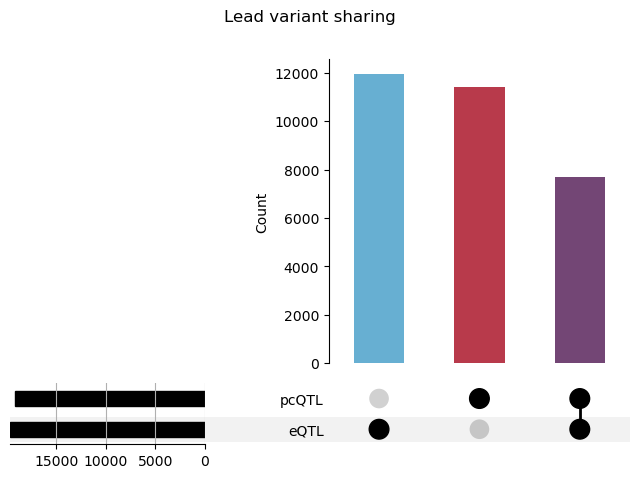

In [50]:
upset = lead_var_grouped.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label", title="Count", elements=8, colors=('#67AFD2','#B83A4B', '#734675'))

upset.plot(fig=fig)

plt.grid(False)
plt.legend([],[], frameon=False)



plt.suptitle('Lead variant sharing')
plt.show()

In [51]:
lead_var_grouped['upset_color_label_multiple'] = lead_var_grouped['upset_color_label']
lead_var_grouped.loc[((lead_var_grouped['upset_color_label'] == 'shared') & (lead_var_grouped['num_e_samelead'] > 1)),'upset_color_label_multiple'] = 'multiple_e_and_pc'
lead_var_grouped.loc[((lead_var_grouped['upset_color_label'] == 'eqtl_only') & (lead_var_grouped['num_e_samelead'] > 1)),'upset_color_label_multiple'] = 'multiple_e'

In [52]:
lead_var_grouped['upset_color_label_multiple'] = pd.Categorical(lead_var_grouped['upset_color_label_multiple'] ,
                                                                ['multiple_e', 'eqtl_only', 'pcqtl_only', 'multiple_e_and_pc', 'shared'])

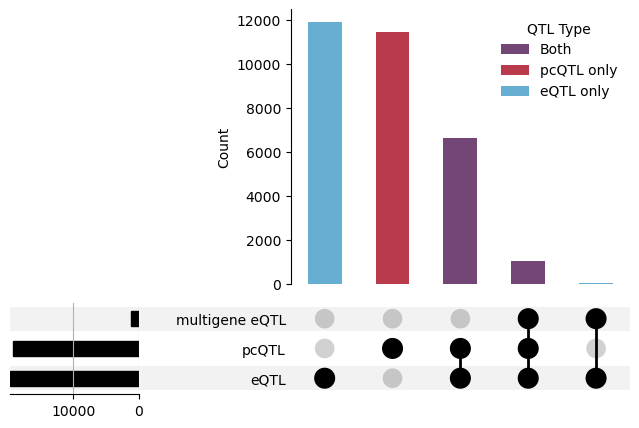

In [61]:
lead_var_grouped['multigene eQTL'] = lead_var_grouped['multiple_e']
upset = lead_var_grouped.set_index('eQTL').set_index('pcQTL', append=True).set_index('multigene eQTL', append=True)


fig = plt.figure(figsize=(8,5))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label", title="Count", elements=8, colors=('#67AFD2','#B83A4B', '#734675'))

upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper right')
leg = plt.gca().get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['Both', 'pcQTL only', 'eQTL only']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
leg.set_frame_on(False)


plt.show()

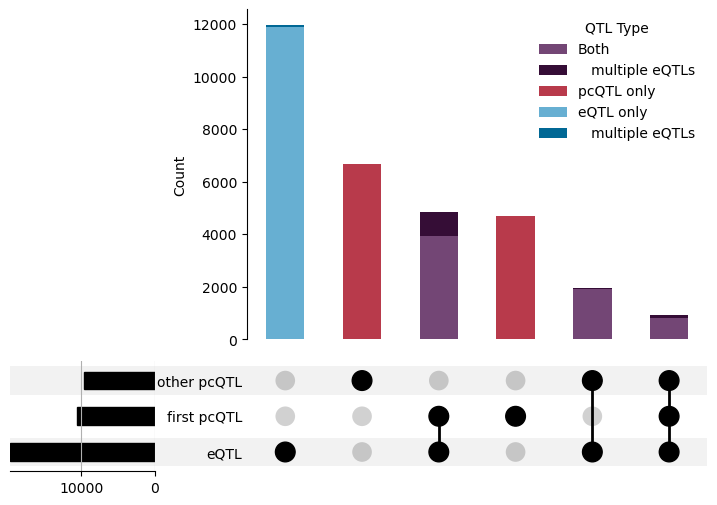

In [30]:
# split out by pc type
lead_var_grouped['first pcQTL'] = lead_var_grouped['cs_id'].astype(str).str.contains('pc1')
lead_var_grouped['other pcQTL'] = (~lead_var_grouped['first pcQTL'] & lead_var_grouped['pcQTL'] )| lead_var_grouped['multiple_pc']

upset = lead_var_grouped.set_index('eQTL').set_index('first pcQTL', append=True).set_index('other pcQTL', append=True)
fig = plt.figure(figsize=(9,6))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None, min_subset_size=100, sort_by="cardinality")  # disable the default bar chart
upset.add_stacked_bars(by="upset_color_label_multiple", title="Count", elements=8, colors=('#016895','#67AFD2', '#B83A4B', '#350D36',  '#734675',))



upset.plot(fig=fig)
plt.grid(False)

plt.legend(loc='upper right')
leg = plt.gca().get_legend()
leg.set_title('QTL Type')
# Change legend labels
leg_texts = ['Both', '   multiple eQTLs', 'pcQTL only', 'eQTL only','   multiple eQTLs']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)
leg.set_frame_on(False)

plt.show()

In [37]:
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

<AxesSubplot: xlabel='exclusive_label', ylabel='percent'>

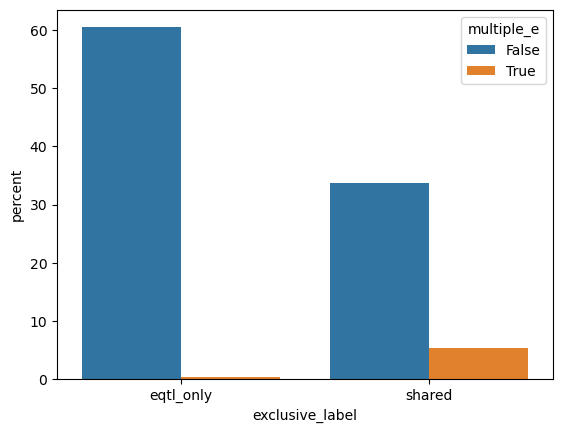

In [43]:
# fraction of multigene signals in pc1/other pc/not at all
sns.countplot(lead_var_grouped[lead_var_grouped['eQTL']], x='exclusive_label', hue='multiple_e', stat='percent')

### Upset membership plot

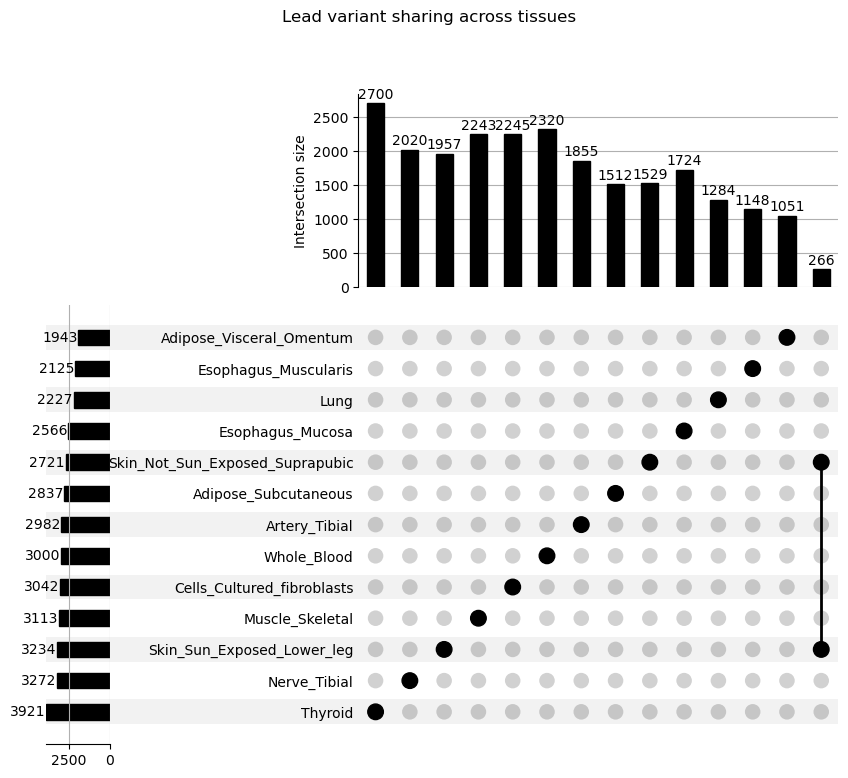

In [ ]:
cs_tissues = full_overlap_df.groupby('lead_variant_id')['tissue_id'].apply(set)
up.UpSet(up.from_memberships(cs_tissues), subset_size='count', min_subset_size=100, show_counts=True).plot()
plt.suptitle('Lead variant sharing across tissues')
plt.show()

#### Overlapping credible sets

In [ ]:
def get_overlap_upset(overlap_df, num_pcs = 2):
    overlap_df['e_overlap'] = overlap_df['num_e_overlap'] > 0

    # make indicator columns
    for i in range(num_pcs):
        overlap_df[f'pc{i+1}_overlap'] = overlap_df[f'num_pc{i+1}_overlap'] > 0
    
    # make upset_plot object
    upset_to_plot = overlap_df.set_index('e_overlap')
    for i in range(num_pcs):
        upset_to_plot = upset_to_plot.set_index(f'pc{i+1}_overlap', append=True)
    return upset_to_plot


In [ ]:
# all tissues, but must overlap in same tissue
# stacked bar to show if multiple egenes overlap or not
upset_dfs=[]
num_pcs = 10

for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    for i in range(num_pcs):
        overlap_df[f'num_pc{i+1}_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=i+1)
    upset_dfs.append(get_overlap_upset(overlap_df, num_pcs=num_pcs))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

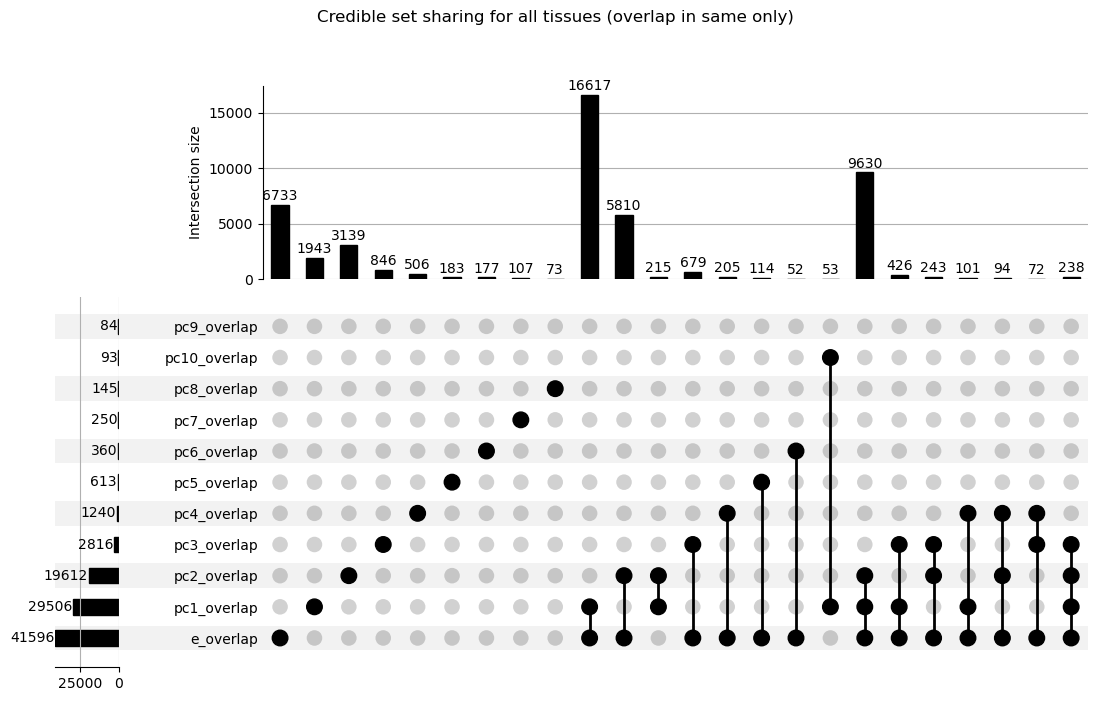

In [ ]:
upset = up.UpSet(full_upset_df,show_counts=True, min_subset_size=50)
upset.plot()
plt.suptitle('Credible set sharing for all tissues (overlap in same only)')
plt.show()

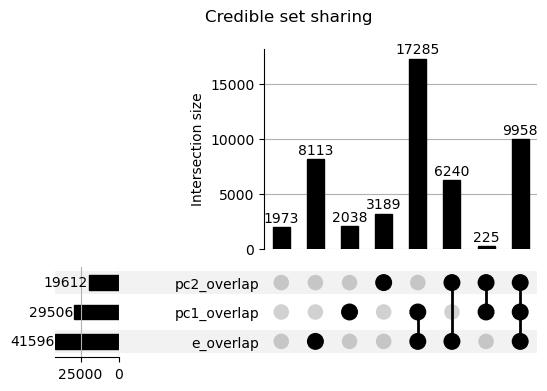

In [ ]:
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    upset_dfs.append(get_overlap_upset(overlap_df))
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

upset = up.UpSet(full_upset_df,show_counts=True)  # disable the default bar chart
upset.plot()
plt.suptitle('Credible set sharing')
plt.show()

In [ ]:
# upset for each tissue individually
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    overlap_df['num_pc1_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc2_samelead'] = overlap_df['pc_samelead'].apply(ast.literal_eval).apply(count_pc, pc_num=2)
    
    upset = up.UpSet(get_overlap_upset(overlap_df), intersection_plot_elements=0,show_counts=True)  # disable the default bar chart
    upset.add_stacked_bars(by="multiple_e_shared", title="Shared by multiple egenes", elements=8)
    upset.plot()
    plt.suptitle(f'Credible set sharing for {tissue_id}')
    plt.show()

## poster

In [4]:
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    # pc overlaps
    overlap_df['num_pc1_overlap'] = overlap_df['pc_overlap'].apply(ast.literal_eval).apply(count_pc, pc_num=1)
    overlap_df['num_pc_overlap'] = overlap_df['pc_overlap'].str.count('pc')
    overlap_df['num_pchigher_overlap'] = overlap_df['num_pc_overlap'] - overlap_df['num_pc1_overlap']

    # make indicator columns 
    overlap_df['first pcQTL'] = overlap_df['num_pc1_overlap'] > 0
    overlap_df['other pcQTL'] = overlap_df['num_pchigher_overlap'] > 0
    overlap_df['eQTL'] = overlap_df['num_e_overlap'] > 0

    # multiple egenes
    overlap_df['multiple_e_shared'] = overlap_df['num_e_overlap']>1  

    upset_to_plot = overlap_df.set_index('eQTL').set_index('first pcQTL', append=True).set_index('other pcQTL', append=True)
    upset_dfs.append(upset_to_plot)
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

In [18]:
mpl.rcParams['figure.dpi']= 1000

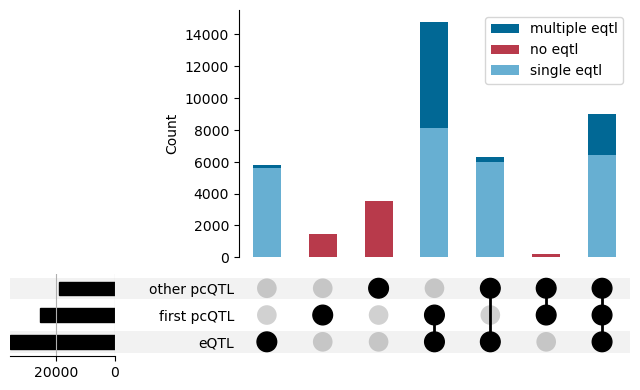

In [5]:
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['multiple_e_shared'], 'multiple eqtl', 'single eqtl')
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['num_e_overlap'] > 0, full_upset_df['multiple_e_shared_label'], 'no eqtl')

fig = plt.figure(figsize=(8, 4.5))
upset = up.UpSet(full_upset_df, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#016895', '#B83A4B', '#67AFD2'))
upset.plot(fig=fig)

plt.grid(False)
plt.show()

In [11]:
mpl.rcParams['figure.dpi']= 100

In [6]:
upset_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    # pc overlaps
    overlap_df['num_pc_overlap'] = overlap_df['pc_overlap'].str.count('pc')

    # make indicator columns 
    overlap_df['pcQTL'] = overlap_df['num_pc_overlap'] > 0
    overlap_df['eQTL'] = overlap_df['num_e_overlap'] > 0

    # multiple egenes
    overlap_df['multiple_e_shared'] = overlap_df['num_e_overlap']>1  

    upset_to_plot = overlap_df.set_index('eQTL').set_index('pcQTL', append=True)
    upset_dfs.append(upset_to_plot)
full_upset_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(upset_dfs, tissue_ids)])

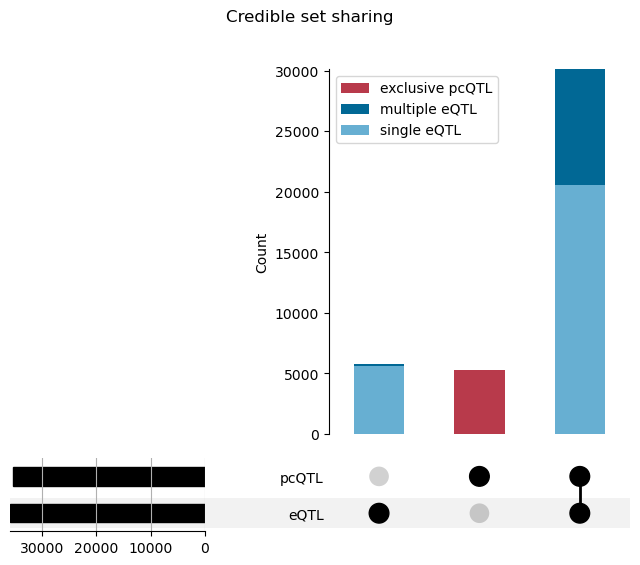

In [7]:
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['multiple_e_shared'], 'multiple eQTL', 'single eQTL')
full_upset_df['multiple_e_shared_label'] = np.where(full_upset_df['num_e_overlap'] > 0, full_upset_df['multiple_e_shared_label'], 'exclusive pcQTL')

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(full_upset_df, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('Credible set sharing')
plt.show()

### coloc upset

write some code for this now and hope it will work later

In [29]:
# load in the qtl colos


# Function to recursively get list of files ending with .qtl_coloc.txt
def get_files(directory):
    file_list = []
    for root, directories, files in os.walk(directory):
        for file in files:
            if file.endswith(".qtl_coloc.txt"):
                file_list.append(os.path.join(root, file))
    return file_list

# Get the list of files
coloc_file_list = get_files(config['coloc_output_dir'])

# Load each file into a DataFrame and concatenate them
cluster_colocs = []
for cluster_file in coloc_file_list:
    cluster_coloc = pd.read_csv(cluster_file, sep='\t')  # Assuming tab-separated file
    cluster_colocs.append(cluster_coloc)

# Concatenate all DataFrames into a single DataFrame
qtl_coloc = pd.concat(cluster_colocs, ignore_index=True)

# Print the combined DataFrame
qtl_coloc.head()

,nsnps,hit1,hit2,PP.H0.abf,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf,idx1,idx2,qtl1_id,qtl2_id,idx1.1
0,8921,chr17_2359666_C_T_b38,chr17_2728691_T_C_b38,0.0,0.0,2.105581e-47,1.0,3.429116e-19,1,1.0,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,NaN
1,8921,chr17_1733780_A_G_b38,chr17_2728691_T_C_b38,0.0,0.0,0.000000e+00,1.0,0.000000e+00,2,1.0,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,NaN
2,8921,chr17_1734008_A_G_b38,chr17_2728691_T_C_b38,0.0,0.0,0.000000e+00,1.0,0.000000e+00,3,1.0,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,NaN
3,8921,chr17_1737499_C_T_b38,chr17_2728691_T_C_b38,0.0,0.0,0.000000e+00,1.0,0.000000e+00,4,1.0,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,NaN
4,8921,chr17_1732098_A_G_b38,chr17_2728691_T_C_b38,0.0,0.0,0.000000e+00,1.0,0.000000e+00,6,1.0,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,ENSG00000167711.13_ENSG00000167716.18_e_ENSG00...,NaN


In [ ]:
# this analysis doesn't totally work, becuase the current script doesn't write it out if there is only one hit. 
# I could update overlap with this info, rather than using it to build a whole new overlap. 
# that allows me to include the 1 cluster dfs 